In [1]:
# STEP 1: Download and unzip the UCI HAR Dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -q "UCI HAR Dataset.zip"
print("Dataset downloaded and unzipped.")


--2025-05-08 18:31:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [     <=>            ]  58.17M  72.6MB/s    in 0.8s    

2025-05-08 18:31:06 (72.6 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Dataset downloaded and unzipped.


In [2]:
import numpy as np
import pandas as pd

# Paths to the dataset folders
DATASET_PATH = "UCI HAR Dataset/"

# Load feature names
features = pd.read_csv(DATASET_PATH + "features.txt", delim_whitespace=True, header=None)
feature_names = features[1].values

# Load training data
X_train = pd.read_csv(DATASET_PATH + "train/X_train.txt", delim_whitespace=True, header=None)
y_train = pd.read_csv(DATASET_PATH + "train/y_train.txt", delim_whitespace=True, header=None)

# Load test data
X_test = pd.read_csv(DATASET_PATH + "test/X_test.txt", delim_whitespace=True, header=None)
y_test = pd.read_csv(DATASET_PATH + "test/y_test.txt", delim_whitespace=True, header=None)

# Convert to NumPy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.ravel() - 1  # Labels start from 1; subtract 1 to start from 0
y_test = y_test.values.ravel() - 1

print(f"Loaded training data: {X_train.shape}")
print(f"Loaded test data: {X_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")


<ipython-input-2-3c655f5e918c>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv(DATASET_PATH + "features.txt", delim_whitespace=True, header=None)
<ipython-input-2-3c655f5e918c>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(DATASET_PATH + "train/X_train.txt", delim_whitespace=True, header=None)
<ipython-input-2-3c655f5e918c>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(DATASET_PATH + "train/y_train.txt", delim_whitespace=True, header=None)
<ipython-input-2-3c655f5e918c>:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test 

Loaded training data: (7352, 561)
Loaded test data: (2947, 561)
Number of classes: 6


<ipython-input-2-3c655f5e918c>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_test = pd.read_csv(DATASET_PATH + "test/y_test.txt", delim_whitespace=True, header=None)


In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input to 3D CNN format: (samples, depth, height, width, channels)
X_train_reshaped = X_train_scaled.reshape(-1, 3, 17, 11, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 3, 17, 11, 1)


# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

print(" Reshaped X_train:", X_train_reshaped.shape)
print("Reshaped X_test:", X_test_reshaped.shape)
print("One-hot encoded labels:", y_train_categorical.shape)


 Reshaped X_train: (7352, 3, 17, 11, 1)
Reshaped X_test: (2947, 3, 17, 11, 1)
One-hot encoded labels: (7352, 6)


In [4]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Input, Dropout, LayerNormalization, MultiHeadAttention, Add, Reshape
from tensorflow.keras.models import Model

#Transformer Encoder Block
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    # Self-attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed forward network
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation='relu')(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([x, y])

#Input Layer
input_shape = (3, 17, 11, 1)  # based on our reshaped data
inputs = Input(shape=input_shape)

#3D CNN Featur Extractor
x = Conv3D(32, kernel_size=(2, 3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling3D(pool_size=(1, 2, 2))(x)
x = Dropout(0.3)(x)

x = Conv3D(64, kernel_size=(2, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2))(x)
x = Dropout(0.3)(x)

#Flatten & Reshape for Transformer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Reshape((4, 32))(x)  # 4 time steps, 32 features (can be tuned)

#Transformer Encoder
x = transformer_encoder(x, head_size=32, num_heads=2, ff_dim=64)

#Classification Headd
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

#Model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3, 17, 11, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 3, 17, 11, │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 3, 8, 5,   │          0 │ conv3d[0][0]      │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3, 8, 5,   │          0 │ max_pooling3d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 3, 8, 5,   │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 3, 4, 2,   │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 3, 4, 2,   │          0 │ max_pooling3d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1536)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    196,736 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 32)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 4, 32)     │         64 │ reshape[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 32)     │      8,416 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 32)     │          0 │ multi_head_atten… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 32)     │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4, 64)     │      2,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4, 64)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4, 32)     │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 32)     │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ add_1[0][0]     

 Total params: 255,654 (998.65 KB)

 Trainable params: 255,654 (998.65 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

#Training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_reshaped, y_train_categorical,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.3752 - loss: 1.3723 - val_accuracy: 0.7634 - val_loss: 0.5080
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.7360 - loss: 0.5813 - val_accuracy: 0.8892 - val_loss: 0.2792
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.8245 - loss: 0.4068 - val_accuracy: 0.9218 - val_loss: 0.1937
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.8764 - loss: 0.3009 - val_accuracy: 0.9198 - val_loss: 0.1879
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.9036 - loss: 0.2459 - val_accuracy: 0.9490 - val_loss: 0.1415
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.9194 - loss: 0.2025 - val_accuracy: 0.9327 - val_loss: 0.1889
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.9337 - loss: 0.1772 - val_accuracy: 0.9443 - val_loss: 0.1748
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.9390 - loss: 0.1608 - val_accu

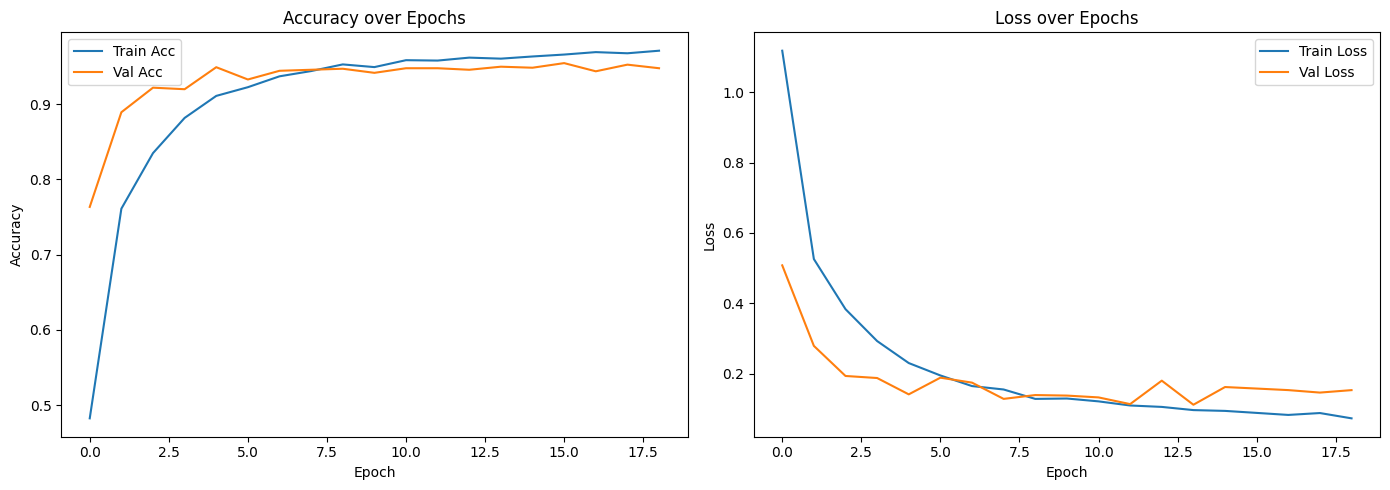

In [6]:
#Plot Accuracy & Loss
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Test Accuracy: 93.65%
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


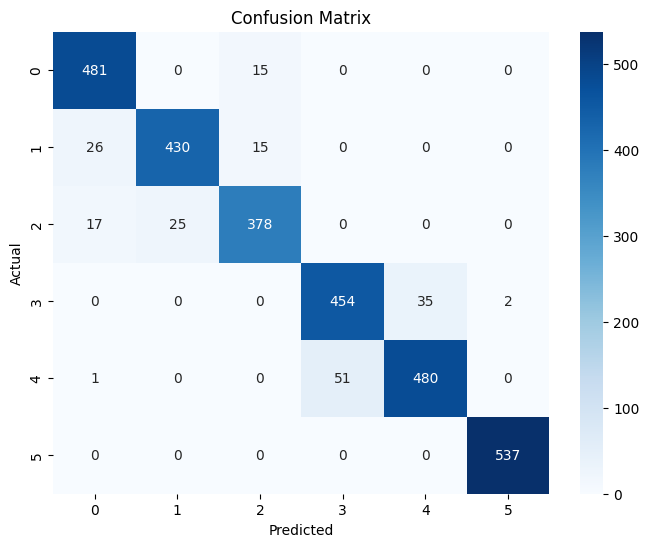


Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       496
           1       0.95      0.91      0.93       471
           2       0.93      0.90      0.91       420
           3       0.90      0.92      0.91       491
           4       0.93      0.90      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.93      0.94      2947
weighted avg       0.94      0.94      0.94      2947



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Evaluate on test set ---
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_categorical, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# --- Predict classes ---
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))


In [8]:
import random

# Pick a random test sample
i = random.randint(0, X_test_reshaped.shape[0] - 1)
sample = X_test_reshaped[i:i+1]
true_label = y_true[i]
pred_label = np.argmax(model.predict(sample), axis=1)[0]

# Activity labels (from UCI HAR dataset)
activity_labels = [
    "Walking",
    "Walking Upstairs",
    "Walking Downstairs",
    "Sitting",
    "Standing",
    "Laying"
]

# Print prediction results
print("Sample index:", i)
print("True Activity:", activity_labels[true_label])
print("Predicted Activity:", activity_labels[pred_label])

# Optional: visualize sample shape
print("Sample shape:", sample.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sample index: 1096
True Activity: Sitting
Predicted Activity: Sitting
Sample shape: (1, 3, 17, 11, 1)
